# Building AI-powered search engine in PostgreSQL and pgvector

In [291]:
import os
from dotenv import load_dotenv
from langchain.vectorstores.pgvector import PGVector
import psycopg2
import numpy as np
from PIL import Image
import pandas as pd
from fashion_clip.fashion_clip import FashionCLIP

## Loading Data

Let's now FashionCLIP first. It's going to take a couple of minutes to download the model from the HuggingFace Hub.

In [292]:
#%%capture
fclip = FashionCLIP('fashion-clip')

In [3]:
#to get the current working directory
directory = os.getcwd()
# Join various path components
path=os.path.join(directory, "data_for_fashion_clip", "subset_data.csv")

In [4]:
subset = pd.read_csv(path)

In [5]:
subset.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
2,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...


In [6]:
subset.to_csv("subset_data.csv", index=False)
f"There are {len(subset)} elements in the dataset"

'There are 3104 elements in the dataset'

##  Task 1: Creating a products table with vector data type and ingesting the data using PGVector


In [95]:
# Assuming you have already obtained the image and text embeddings
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()
article_id=subset["article_id"].tolist()

# Create image embeddings and text embeddings
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

# Normalize the embeddings to unit norm
image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [05:30<00:00,  3.40s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:11<00:00,  8.37it/s]


# Utils 

In [8]:
def test_connection(conn):
    # Create a cursor object
    cursor = conn.cursor()
    # Execute a test query
    cursor.execute("SELECT version();")
    # Fetch the result
    result = cursor.fetchone()
    print("Connection successful!")
    print("PostgreSQL version:", result[0])
    # Close the cursor and connection
    cursor.close()
    #conn.close()

In [250]:
import numpy as np
import psycopg2

# Define the embedding function
def my_embedding_function(text):
    # Generate text embeddings using fclip.encode_text
    text_embedding = fclip.encode_text([text], batch_size=1)
    # Normalize the embeddings to unit norm
    text_embedding = text_embedding / np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)
    return text_embedding[0]  # Return the single text embedding


In [ ]:
from IPython.display import display
def display_id(id_of_matched_object):
    print("id=",id_of_matched_object)
    # selecting rows based on condition
    subset.loc[subset['article_id'] ==id_of_matched_object ]
    #found_object = subset["article_id"].iloc[id_of_matched_object].tolist()
    found_object=id_of_matched_object
    fixed_height = 224
    image = Image.open(f"data_for_fashion_clip/{found_object}.jpg")
    height_percent = (fixed_height / float(image.size[1]))
    width_size = int((float(image.size[0]) * float(height_percent)))
    image = image.resize((width_size, fixed_height), Image.NEAREST)
    display(image)

## Task 2 : Connection to the Server
Connect to server for PostgreSQL and create a products table with the vector data type and ingest the data. Then, create an index for the similarity search for finding the nearest L2 distance neighbors.

In [205]:
import psycopg2
from pgvector.psycopg2 import register_vector

# Establish connection to the PostgreSQL Docker container
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="testuser",
    password="testpwd",
    database="vectordb"
)

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Define the SQL query to drop the table if it exists
drop_table_query = "DROP TABLE IF EXISTS products;"

# Execute the SQL query to drop the table
cursor.execute(drop_table_query)

# Commit the changes to the database
conn.commit()

# Define the SQL query to create the table
create_table_query = """
CREATE TABLE products (
    id SERIAL PRIMARY KEY,
    image_embedding vector(512), -- Specify the shape of the vector
    text_embedding vector(512), -- Specify the shape of the vector
    description TEXT, -- description text
    article INTEGER
);
"""

# Execute the SQL query to create the table
cursor.execute(create_table_query)

# Define the SQL query to insert the data into the table
insert_data_query = "INSERT INTO products (image_embedding, text_embedding, description, article) VALUES (%s, %s, %s, %s)"

# Iterate through the embeddings and insert them into the table
for image_embedding, text_embedding, description, article in zip(image_embeddings, text_embeddings, texts, article_id):
    try:
        cursor.execute(insert_data_query, (image_embedding.tolist(), text_embedding.tolist(), description, article))
        conn.commit()  # Commit the transaction after each insert

    except Exception as e:
        print(f"Error inserting data: {e}")
        # Rollback the transaction in case of an error
        conn.rollback()

# Create an index for similarity search using L2 distance
create_index_query = "CREATE INDEX ON products USING ivfflat (text_embedding vector_l2_ops) WITH (lists = 100);"
cursor.execute(create_index_query)

# Commit the changes to the database
conn.commit()

# Close the cursor
cursor.close()

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Execute the VACUUM ANALYZE query outside the transaction block
conn.autocommit = True
vacuum_analyze_query = "VACUUM ANALYZE products;"
cursor.execute(vacuum_analyze_query)

# Get the column names in the products table
cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'products';")
column_names = [row[0] for row in cursor.fetchall()]
print("Column Names:", column_names)

# Close the cursor and connection
cursor.close()
conn.close()


Column Names: ['id', 'image_embedding', 'text_embedding', 'article', 'description']


## Task 3 Similarity search on the products table
Run a query to perform a similarity search on the products table in RDS for PostgreSQL using the pgvector extension

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.53it/s]

Product Item Id: 665
Article: 599719009
Description: Short shorts in woven fabric with a zip fly and button, side pockets and fake welt back pockets.
----------------------
Product Item Id: 1487
Article: 698426002
Description: Shorts in a cotton weave with an adjustable, elasticated waist, fly with a press-stud, side pockets and fake welt back pockets.
----------------------
id= 698426002


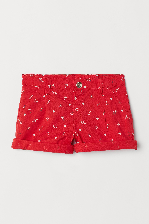

In [309]:
data = my_embedding_function("a pair of pink short")
#data= fclip.encode_text(["a pair of pink shorts"], 32)[0]
data_list = data.tolist()  # Convert numpy.ndarray to list
# Establish connection to the PostgreSQL Docker container
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="testuser",
    password="testpwd",
    database="vectordb"
)

# Create a cursor object to execute SQL queries
cursor = conn.cursor()
# Perform similarity search query
cursor.execute("""
    SELECT id, article,description, text_embedding
    FROM products
    ORDER BY text_embedding <-> %s::vector
    LIMIT 2;
""", (data_list,))

# Fetch the results
results = cursor.fetchall()

# Process and display the results
for result in results:
    product_id = result[0]
    print("Product Item Id:", product_id)
    print("Article:", result[1])
    print("Description:", result[2])
    print("----------------------")
# Close the cursor and connection
cursor.close()
conn.close()

id_of_matched_object=result[1]
display_id(id_of_matched_object) 

In [307]:
# Process and display the results
#for result in results:
#    id_of_matched_object= result[1]
#    display_id(id_of_matched_object) 